# Anomaly Detection Using RNN

Anomaly detection detects data points in data that does not fit well with the rest of data. In this notebook we demonstrate how to do unsupervised anomaly detection using recurrent nueral network (RNN) model.

We used one of the dataset in Numenta Anomaly Benchmark (NAB) ([link](https://github.com/numenta/NAB)) for demo, i.e. NYC taxi passengers dataset, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot. We use RNN to learn from 50 previous values, and predict just the 1 next value. The data points whose actual values are distant from predicted values are considered anomalies (distance threshold can be adjusted as needed).
  
References: 
* Unsupervised real-time anomaly detection for streaming data ([link](https://www.sciencedirect.com/science/article/pii/S0925231217309864)).

## Intialization

* import necesary libraries

In [1]:
# set plotting style
# if you don't have jupyterthemes no need to run this
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    pass

In [2]:
import os

from zoo.common.nncontext import *
sc = init_nncontext("Anomaly Detection Example")
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
%matplotlib inline
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing

Prepending /home/henryliu/anaconda3/envs/zoo/lib/python3.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /home/henryliu/anaconda3/envs/zoo/lib/python3.7/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.8.0-spark_2.4.3-0.5.1-jar-with-dependencies.jar to BIGDL_JARS
Prepending /home/henryliu/anaconda3/envs/zoo/lib/python3.7/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
Populating the interactive namespace from numpy and matplotlib


* import necessary modules

In [3]:
from zoo.pipeline.api.keras.layers import Dense, Dropout, LSTM
from zoo.pipeline.api.keras.models import Sequential

## Data Check

* read data

In [4]:
try:
    dataset_path = "nyc_taxi.csv"
    df = pd.read_csv(dataset_path)
except Exception as e:
    print("nyc_taxi.csv doesn't exist")
    print("you can run $ANALYTICS_ZOO_HOME/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv")

* Understand the data.

Each record is in format of (timestamp, value). Timestamps range between 2014-07-01 and 2015-01-31. 

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
timestamp    10320 non-null object
value        10320 non-null int64
dtypes: int64(1), object(1)
memory usage: 161.4+ KB
None


In [7]:
# check the timestamp format and frequence 
print(df['timestamp'].head(5))

0    2014-07-01 00:00:00
1    2014-07-01 00:30:00
2    2014-07-01 01:00:00
3    2014-07-01 01:30:00
4    2014-07-01 02:00:00
Name: timestamp, dtype: object


In [8]:
# check the mean of passenger number 
print(df['value'].mean())

15137.569379844961


/home/henryliu/anaconda3/envs/zoo/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


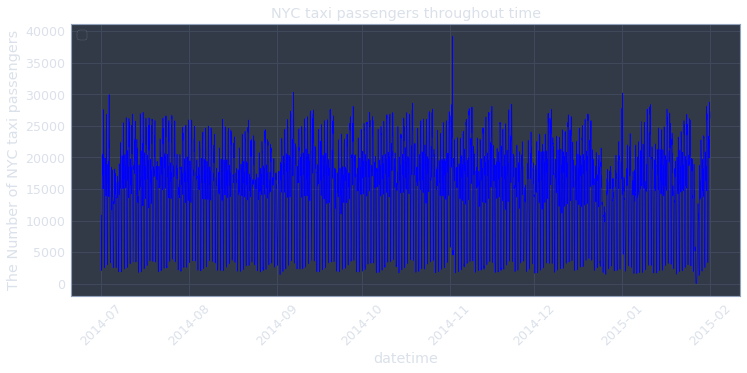

In [6]:
# change the type of timestamp column for plotting
df['datetime'] = pd.to_datetime(df['timestamp'])

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df['datetime'], df['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('The Number of NYC taxi passengers')
plt.legend(loc='upper left')
plt.show()

In [10]:
df.head(5)

,timestamp,value,datetime
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00


## Feature engineering

* Extracting some useful features

In [7]:
# the hours when people are awake (6:00-00:00)
df['hours'] = df['datetime'].dt.hour
df['awake'] = (((df['hours'] >= 6) & (df['hours'] <= 23)) | (df['hours'] == 0)).astype(int)

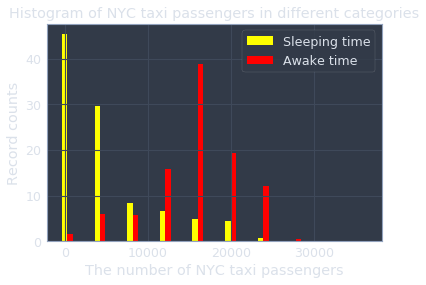

In [8]:
# creation of 2 distinct categories that seem useful (sleeping time and awake time)
df['categories'] = df['awake']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='yellow', label='Sleeping time')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='red', label ='Awake time')
ax.set_title('Histogram of NYC taxi passengers in different categories')

plt.xlabel('The number of NYC taxi passengers')
plt.ylabel('Record counts')
plt.legend()
plt.show()

In [13]:
df['awake'].head(4)

0    1
1    1
2    0
3    0
Name: awake, dtype: int64

In [14]:
df['timestamp'].head(4)

0    2014-07-01 00:00:00
1    2014-07-01 00:30:00
2    2014-07-01 01:00:00
3    2014-07-01 01:30:00
Name: timestamp, dtype: object

From the above result, we can conclude:
- more people take taxi when they are awake

## Data Preparation

* Standardizing data and spliting them into the train data and the test data

In [9]:
#select and standardize data
data_n = df[['value', 'hours', 'awake']]
standard_scaler = preprocessing.StandardScaler()
np_scaled = standard_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

#important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 12
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

#test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

/home/henryliu/anaconda3/envs/zoo/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/henryliu/anaconda3/envs/zoo/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/home/henryliu/anaconda3/envs/zoo/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/henryliu/anaconda3/envs/zoo/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [16]:
x_test[2], y_test[1]

(array([-1.50112838, -1.08347268, -1.94935887]), -1.5011283792639645)

* Unroll data: for the data point at index i, create a sequence from i to (i+unroll_length)

for example, if unroll_length=5

[[1]

 [2]
 
 [3]
 
 [4]
 
 [5]
 
 [6]
 
 [7]
 
 [8]
 
 [9]
 
 [10]
 
...

]

will be unrolled to create following sequences

[[ 1,  2,  3,  4,  5]

 [ 2,  3,  4,  5,  6]
 
 [ 3,  4,  5,  6,  7]
 
 [ 4,  5,  6,  7,  8]

 [ 5,  6,  7,  8,  9]
 
 [ 6,  7,  8,  9,  10]
 
 ...
 
 ]

In [10]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
q_train = unroll(x_train,unroll_length)
q_test  = unroll(x_test,unroll_length)
y_train = y_train[unroll_length-1:-1]
y_test  = y_test[unroll_length-1:-1]

# see the shape
print("q_train", q_train.shape)
print("y_train", y_train.shape)
print("q_test", q_test.shape)
print("y_test", y_test.shape)

q_train (9294, 12, 3)
y_train (9294,)
q_test (1000, 12, 3)
y_test (1000,)


In [11]:
# prepare MTNet data
# n=7 as length of historical data
# generate the historical data X_i for each idx
def historical(q_train, idx, unroll_length=48, history_length=7):
    assert(history_length*unroll_length < idx), "Invalid index, not enough historical data"
    result = []
    for i in range(history_length,0,-1):
        result.append(q_train[idx-unroll_length*i])
    return np.asarray(result)

In [12]:
# generate X_i for all timestamps
history_length=7
result = []
start_cut = (history_length+1) * unroll_length + 1
for i in range(start_cut,q_train.shape[0]):
    result.append(historical(q_train, i, unroll_length, history_length))
X_train = np.asarray(result)
q_train = q_train[start_cut:]
y_train = y_train[start_cut:].reshape(-1,1)
result = []
for i in range(start_cut,q_test.shape[0]):
    result.append(historical(q_test, i, unroll_length, history_length))
X_test = np.asarray(result)
q_test = q_test[start_cut:]
y_test = y_test[start_cut:].reshape(-1,1)

In [13]:
# input shape
print(X_train.shape)
print(q_train.shape)
print(y_train.shape)
print(X_test.shape)
print(q_test.shape)
print(y_test.shape)

(9197, 7, 12, 3)
(9197, 12, 3)
(9197, 1)
(903, 7, 12, 3)
(903, 12, 3)
(903, 1)


In [14]:
# store the data as batches in batch_size=100
batch_data_train = [(X_train[100*i:100*(i+1)], q_train[100*i:100*(i+1)], y_train[100*i:100*(i+1)]) for i in range(q_train.shape[0]//100)]
batch_data_test = [(X_test[100*i:100*(i+1)], q_test[100*i:100*(i+1)], y_test[100*i:100*(i+1)]) for i in range(q_test.shape[0]//100) ]

## Build MTNet

In [15]:
import tensorflow as tf
class MTNet:
    def __init__(self, config, scope = 'MTNet'):
        self.config = config
        with tf.variable_scope(scope, reuse = False):
            X = tf.placeholder(tf.float32, shape = [None, self.config.n, self.config.T, self.config.D])
            Q = tf.placeholder(tf.float32, shape = [None, self.config.T, self.config.D])
            Y = tf.placeholder(tf.float32, shape = [None, self.config.K])

            lr = tf.placeholder(tf.float32)
            input_keep_prob = tf.placeholder(tf.float32)
            output_keep_prob = tf.placeholder(tf.float32)

            # ------- no-linear component----------------
            last_rnn_hid_size = self.config.en_rnn_hidden_sizes[-1]
            # <batch_size, n, en_rnn_hidden_sizes>u
            m_is = self.__encoder(X, self.config.n, scope = 'm')
            c_is = self.__encoder(X, self.config.n, scope = 'c')
            # <batch_size, 1, en_rnn_hidden_sizes>
            u = self.__encoder(tf.reshape(Q, shape = [-1, 1, self.config.T, self.config.D]), 1, scope = 'in')

            p_is = tf.matmul(m_is, tf.transpose(u, perm = [0, 2, 1]))

            # using softmax
            p_is = tf.squeeze(p_is, axis = [-1])
            p_is = tf.nn.softmax(p_is)
            # <batch_size, n, 1>
            p_is = tf.expand_dims(p_is, -1)

            # using sigmoid
            # p_is = tf.nn.sigmoid(p_is)

            # for summary
            #p_is_mean, _ = tf.metrics.mean_tensor(p_is, updates_collections = 'summary_ops', name = 'p_is')
            #tf.summary.histogram('p_is', p_is_mean)

            # <batch_size, n, en_rnn_hidden_sizes> = <batch_size, n, en_rnn_hidden_sizes> * <batch_size, n, 1>
            o_is = tf.multiply(c_is, p_is)

            # :: last_rnn_hid_size * (self.config.n + 1) :: is the concatination of (12)
            # following varaibles are a single layer vanilla net
            pred_w = tf.get_variable('pred_w', shape = [last_rnn_hid_size * (self.config.n + 1), self.config.K],
                                     dtype = tf.float32, initializer = tf.truncated_normal_initializer(stddev = 0.1))
            pred_b = tf.get_variable('pred_b', shape = [self.config.K],
                                     dtype = tf.float32, initializer = tf.constant_initializer(0.1))
            
            pred_x = tf.concat([o_is, u], axis = 1)
            pred_x = tf.reshape(pred_x, shape = [-1, last_rnn_hid_size * (self.config.n + 1)])

            # <batch_size, D>
            y_pred = tf.matmul(pred_x, pred_w) + pred_b

            # ------------ ar component ------------
            with tf.variable_scope('AutoRegression'):
                if self.config.highway_window > 0: # highway_window is basically (s^ar -1) 
                    highway_ws = tf.get_variable('highway_ws', shape = [self.config.highway_window * self.config.D, self.config.K],
                                                dtype = tf.float32,
                                                initializer = tf.truncated_normal_initializer(stddev = 0.1))
                    highway_b = tf.get_variable('highway_b', shape = [self.config.K], dtype = tf.float32,
                                                initializer = tf.constant_initializer(0.1))

                    highway_x = tf.reshape(Q[:, -self.config.highway_window:], shape = [-1, self.config.highway_window * self.config.D])
                    y_pred_l = tf.matmul(highway_x, highway_ws) + highway_b

                    # y_pred_l = tf.matmul(Q[:, -1], highway_ws[0]) + highway_b
                    # _, y_pred_l = tf.while_loop(lambda i, _ : tf.less(i, self.config.highway_window),
                    #                             lambda i, acc : (i + 1, tf.matmul(Q[:, self.config.T - i - 1], highway_ws[i]) + acc),
                    #                             loop_vars = [1, y_pred_l])
                    y_pred += y_pred_l


        # metrics summary
        #mae_loss, _ = tf.metrics.mean_absolute_error(Y, y_pred, updates_collections = 'summary_ops', name = 'mae_metric')
        #tf.summary.scalar('mae_loss', mae_loss)

        rmse_loss, _ = tf.metrics.root_mean_squared_error(Y, y_pred, updates_collections = 'summary_ops', name = 'rmse_metric')
        tf.summary.scalar("rmse_loss", rmse_loss)

        statistics_vars = tf.get_collection(tf.GraphKeys.METRIC_VARIABLES)
        statistics_vars_initializer = tf.variables_initializer(var_list = statistics_vars)

        loss = tf.losses.absolute_difference(Y, y_pred)
        with tf.name_scope('Train'):
            train_op = tf.train.AdamOptimizer(lr).minimize(loss)

        # assignment
        self.X = X
        self.Q = Q
        self.Y = Y
        self.input_keep_prob = input_keep_prob
        self.output_keep_prob = output_keep_prob
        self.lr = lr
        self.y_pred = y_pred
        self.loss = loss
        self.train_op = train_op

        self.reset_statistics_vars = statistics_vars_initializer
        self.merged_summary = tf.summary.merge_all()
        self.summary_updates = tf.get_collection('summary_ops')

    def __encoder(self, origin_input_x, n, strides = [1, 1, 1, 1], padding = 'VALID', activation_func = tf.nn.relu, scope = 'Encoder'):
        '''
            Treat batch_size dimension and n dimension as one batch_size dimension (batch_size * n).
        :param input_x:  <batch_size, n, T, D>
        :param strides:
        :param padding:
        :param scope:
        :return: the embedded of the input_x <batch_size, n, last_rnn_hid_size>
        '''
        # constant
        scope = 'Encoder_' + scope
        batch_size_new = self.config.batch_size * n
        Tc = self.config.T - self.config.W + 1
        last_rnn_hidden_size = self.config.en_rnn_hidden_sizes[-1]

        # reshape input_x : <batch_size * n, T, D, 1>
        input_x = tf.reshape(origin_input_x, shape = [-1, self.config.T, self.config.D, 1])

        with tf.variable_scope(scope, reuse = tf.AUTO_REUSE):
            # cnn parameters
            with tf.variable_scope('CNN', reuse = tf.AUTO_REUSE):
                w_conv1 = tf.get_variable('w_conv1', shape = [self.config.W, self.config.D, 1, self.config.en_conv_hidden_size], dtype = tf.float32, initializer = tf.truncated_normal_initializer(stddev = 0.1))
                b_conv1 = tf.get_variable('b_conv1', shape = [self.config.en_conv_hidden_size], dtype = tf.float32, initializer = tf.constant_initializer(0.1))

                # <batch_size_new, Tc, 1, en_conv_hidden_size>
                h_conv1 = activation_func(tf.nn.conv2d(input_x, w_conv1, strides, padding = padding) + b_conv1)
                if self.config.input_keep_prob < 1:
                    h_conv1 = tf.nn.dropout(h_conv1, self.config.input_keep_prob)


            # tmporal attention layer and gru layer
            # rnns
            rnns = [tf.nn.rnn_cell.GRUCell(h_size, activation = activation_func) for h_size in self.config.en_rnn_hidden_sizes]
            # dropout
            if self.config.input_keep_prob < 1 or self.config.output_keep_prob < 1:
                rnns = [tf.nn.rnn_cell.DropoutWrapper(rnn,
                                                      input_keep_prob = self.config.input_keep_prob,
                                                      output_keep_prob = self.config.output_keep_prob)
                        for rnn in rnns]

            if len(rnns) > 1:
                rnns = tf.nn.rnn_cell.MultiRNNCell(rnns)
            else:
                rnns = rnns[0]

            # attention layer

            # attention weights
            attr_v = tf.get_variable('attr_v', shape = [Tc, 1], dtype = tf.float32, initializer = tf.truncated_normal_initializer(stddev = 0.1))
            attr_w = tf.get_variable('attr_w', shape = [last_rnn_hidden_size, Tc], dtype = tf.float32, initializer = tf.truncated_normal_initializer(stddev = 0.1))
            attr_u = tf.get_variable('attr_u', shape = [Tc, Tc], dtype = tf.float32, initializer = tf.truncated_normal_initializer(stddev = 0.1))

            # rnn inputs
            # <batch_size, n, Tc, en_conv_hidden_size>
            rnn_input = tf.reshape(h_conv1, shape=[-1, n, Tc, self.config.en_conv_hidden_size])

            # n * <batch_size, last_rnns_size>
            res_hstates = tf.TensorArray(tf.float32, n)
            for k in range(n):
                # <batch_size, en_conv_hidden_size, Tc>
                attr_input = tf.transpose(rnn_input[:, k], perm = [0, 2, 1])

                # <batch_size, last_rnn_hidden_size>
                s_state = rnns.zero_state(self.config.batch_size, tf.float32)
                if len(self.config.en_rnn_hidden_sizes) > 1:
                    h_state = s_state[-1]
                else:
                    h_state = s_state

                for t in range(Tc):
                    # attr_v = tf.Variable(tf.truncated_normal(shape=[Tc, 1], stddev=0.1, dtype=tf.float32), name='attr_v')
                    # attr_w = tf.Variable(tf.truncated_normal(shape=[last_rnn_hidden_size, Tc], stddev=0.1, dtype=tf.float32), name='attr_w')
                    # attr_u = tf.Variable(tf.truncated_normal(shape=[Tc, Tc], stddev=0.1, dtype=tf.float32), name='attr_u')

                    # h(t-1) dot attr_w
                    h_part = tf.matmul(h_state, attr_w)

                    # en_conv_hidden_size * <batch_size_new, 1>
                    e_ks = tf.TensorArray(tf.float32, self.config.en_conv_hidden_size)
                    _, output = tf.while_loop(lambda i, _ : tf.less(i, self.config.en_conv_hidden_size),
                                              lambda i, output_ta : (i + 1, output_ta.write(i, tf.matmul(tf.tanh( h_part + tf.matmul(attr_input[:, i], attr_u) ), attr_v))),
                                              [0, e_ks])
                                              # : tf.while_loop(cond, body, loop_vars ) :
                                              # : TENSOR.write(idx, content) : write content at index
                    # <batch_size, en_conv_hidden_size, 1>
                    e_ks = tf.transpose(output.stack(), perm = [1, 0, 2])
                    e_ks = tf.reshape(e_ks, shape = [-1, self.config.en_conv_hidden_size])

                    # <batch_size, en_conv_hidden_size>
                    a_ks = tf.nn.softmax(e_ks)

                    x_t = tf.matmul( tf.expand_dims(attr_input[:, :, t], -2), tf.matrix_diag(a_ks))
                    # <batch_size, en_conv_hidden_size>
                    x_t = tf.reshape(x_t, shape = [-1, self.config.en_conv_hidden_size])

                    h_state, s_state = rnns(x_t, s_state)

                res_hstates = res_hstates.write(k, h_state)

        return tf.transpose(res_hstates.stack(), perm = [1, 0, 2])

    def train(self, one_batch, sess):
        fd = self.get_feed_dict(one_batch, True)
        _, loss, pred = sess.run([self.train_op, self.loss, self.y_pred], feed_dict = fd)
        sess.run(self.summary_updates, feed_dict = fd)
        return loss, pred

    def predict(self, one_batch, sess):
        fd = self.get_feed_dict(one_batch, False)
        loss, pred = sess.run([self.loss, self.y_pred], feed_dict = fd)
        sess.run(self.summary_updates, feed_dict = fd)
        return loss, pred

    def get_feed_dict(self, one_batch, is_train):
        if is_train:
            fd = {self.X : one_batch[0],
                  self.Q : one_batch[1],
                  self.Y : one_batch[2],
                  self.input_keep_prob : self.config.input_keep_prob,
                  self.output_keep_prob : self.config.output_keep_prob,
                  self.lr : self.config.lr}
        else:
            fd = {self.X : one_batch[0],
                  self.Q : one_batch[1],
                  self.Y : one_batch[2],
                  self.input_keep_prob : 1.0,
                  self.output_keep_prob :1.0,
                  self.lr: self.config.lr}
        return fd

/home/henryliu/anaconda3/envs/zoo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/henryliu/anaconda3/envs/zoo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/henryliu/anaconda3/envs/zoo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/henryliu/anaconda3/envs/zoo/lib/python3.7/s

## Configuration

In [16]:
class NABConfig:
    def __init__(self):
        self.T = 12 # timestep
        self.W = 2 # convolution window size (convolution filter height)` ?
        self.n = 7 # the number of the long-term memory series
        self.highway_window = 10  # the window size of ar model

        self.D = 3  # input's variable dimension (convolution filter width)
        self.K = 1 # output's variable dimension

        # self.horizon = 6 # the horizon of predicted value

        self.en_conv_hidden_size = 16
        self.en_rnn_hidden_sizes = [16, 16]  # last size is equal to en_conv_hidden_size 

        self.input_keep_prob = 0.8
        self.output_keep_prob = 1.0

        self.lr = 0.001
        self.batch_size = 100

## Train the model

In [20]:
from functools import reduce
from operator import mul

def make_config_string(config):
    return "T%s_W%s_n%s_hw%s_dropin%s_cnn%s_rnn%s" % \
           (config.T, config.W, config.n, config.highway_window, config.input_keep_prob,
            config.en_conv_hidden_size, '_'.join(list(map(str,config.en_rnn_hidden_sizes))))

def get_num_params():
    num_params = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        num_params += reduce(mul, [dim.value for dim in shape], 1)
    return num_params

def run_one_config(config, train_batch_data, valid_batch_data, model=None):
    epochs = 15

    # learning rate decay
    max_lr = 0.003
    min_lr = 0.0001
    decay_epochs = 60

    # build model
    with tf.Session() as sess:
        # model = MTNet(config)
        saver = tf.train.Saver()
        model_path = make_model_path(config)
    
        print('----------Train Config:', make_config_string(config), '. Total epochs:', epochs)
        print('Trainable parameter count:', get_num_params())

        # Actually run
        sess.run(tf.global_variables_initializer())

        best_score = float('inf')

        # indicate the score name
        score1_name, score2_name= ['MAE', 'RMSE']

        for i in range(epochs):
            print("epoch(%d/%d)" % (i, epochs))
            
            # decay lr
            config.lr = min_lr + (max_lr - min_lr) * math.exp(-i/decay_epochs)

            # train one epoch
            run_one_epoch(sess, model, train_batch_data, i, True)
            # evaluate
            if i % 3 == 0:
                loss, score1, score2 = run_one_epoch(sess, model, valid_batch_data, i, False)
                if best_score > score2:
                    best_score = score2
                    # save model
                    saver.save(sess, model_path)
                    print('Epoch', i, 'Test Loss:', loss, score1_name,':', score1, score2_name, ':', score2)

        print('---------Best score:', score2_name, ':', best_score)

    # free default graph
    tf.reset_default_graph()
    
def make_model_path(config):
    dir = 'NAB_save'
    if not os.path.exists(dir):
        os.makedirs(dir)
    return os.path.join(dir, make_config_string(config), 'mtnet.ckpt')
    
def run_one_epoch(sess, model, batch_data, epoch_num, is_train = True):
    # reset statistics variables
    sess.run(model.reset_statistics_vars)

    if is_train :
        run_func = model.train
    else:
        run_func = model.predict

    y_pred_list = []
    y_real_list = []
    loss_list = []

    for ds in batch_data:
        # print("\tstart new batch")
        loss, pred = run_func(ds, sess)
        y_pred_list.append(pred)
        y_real_list.append(ds[-1])
        loss_list.append(loss)

    # inverse norm
    y_pred_list = np.reshape(y_pred_list, [-1, model.config.K])
    y_real_list = np.reshape(y_real_list, [-1, model.config.K])

    # y_pred_list = ds_handler.inverse_transform(y_pred_list)
    # y_real_list = ds_handler.inverse_transform(y_real_list)

    # real value loss
    loss = np.mean(loss_list)

    # summary
    # model's summary
    summary = sess.run(model.merged_summary)
    # summary_writer.add_summary(summary, epoch_num)
    # other summary
    mae = np.mean(abs(np.subtract(y_pred_list, y_real_list)))
    rmse = np.sqrt(np.mean(np.subtract(y_pred_list, y_real_list) ** 2))

    real_mae_summary = tf.Summary()
    real_mae_summary.value.add(tag='real_mae', simple_value=mae)
    # summary_writer.add_summary(real_mae_summary, epoch_num)

    real_rmse_summary = tf.Summary()
    real_rmse_summary.value.add(tag='real_rmse', simple_value=rmse)
    # summary_writer.add_summary(real_rmse_summary, epoch_num)
    return loss, mae, rmse

In [34]:
# build model takes 50s on i7-8700
nab_config = NABConfig()
model = MTNet(nab_config) # for debugging concern

In [81]:
%%time
# Train the model
print("Training begins.")
run_one_config(nab_config, batch_data_train, batch_data_test, model)
print("Training completed.")

----------Train Config: T12_W2_n7_hw10_dropin0.8_cnn16_rnn[16, 16] . Total epochs: 3
Trainable parameter count: 10924
start new epoch
start new epoch
Epoch 0 Test Loss: 0.37762135 MAE : 0.37762138741223916 RMSE : 0.4992961588140739
start new epoch
start new epoch
Epoch 1 Test Loss: 0.25113875 MAE : 0.25113875741146385 RMSE : 0.32723263291308846
start new epoch
start new epoch
Epoch 2 Test Loss: 0.20935059 MAE : 0.2093505856964366 RMSE : 0.2660772900394927
---------Best score: RMSE : 0.2660772900394927
Training completed.
CPU times: user 2min 41s, sys: 79.5 ms, total: 2min 41s
Wall time: 2min 41s


## Prediction

* BigDL models make inferences based on the given data using model.predict(val_rdd) API. A result of RDD is returned. predict_class returns the predicted points. 

In [21]:
model_path = make_model_path(nab_config)

In [33]:
tf.reset_default_graph()

In [36]:
# load session if needed
LOAD_MODEL = 0

# load and predict
y_pred_list = []
y_real_list = []
with tf.Session() as sess:
    if LOAD_MODEL:
        sess.run(model.reset_statistics_vars)
        model_path = make_model_path(nab_config)
        saver = tf.train.Saver()
        # saver = tf.train.import_meta_graph('NAB_save/T12_W2_n7_hw10_dropin0.8_cnn16_rnn16_16/mtnet.ckpt.meta')
        saver.restore(sess, 'NAB_save/T12_W2_n7_hw10_dropin0.8_cnn16_rnn16_16/mtnet.ckpt')
        # saver.restore(sess, model_path)
        # sess.run(tf.initializers.local_variables())
    print("start prediction")
    for ds in batch_data_test:
        loss, pred = model.predict(ds, sess)
        y_pred_list.append(pred)
        y_real_list.append(ds[-1])
y_test = np.asarray(y_real_list)
y_pred = np.asarray(y_pred_list)

INFO:tensorflow:Restoring parameters from NAB_save/T12_W2_n7_hw10_dropin0.8_cnn16_rnn16_16/mtnet.ckpt
start prediction
start prediction
start prediction
start prediction
start prediction
start prediction
start prediction
start prediction
start prediction


In [40]:
# reshape
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

# create the list of difference between prediction and test data
diff= abs(y_pred - y_test)
ratio= abs(y_pred/y_test)

## Evaluation

* plot the prediction and the reality

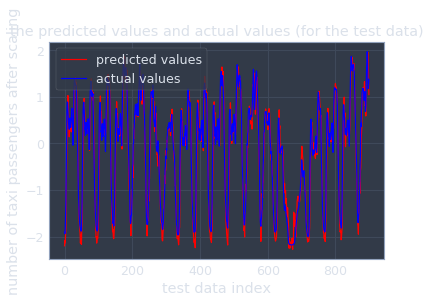

In [44]:
# plot the predicted values and actual values (for the test data)
fig, axs = plt.subplots()

axs.plot(y_pred,color='red', label='predicted values')
axs.plot(y_test,color='blue', label='actual values')
axs.set_title('the predicted values and actual values (for the test data)')

plt.xlabel('test data index')
plt.ylabel('number of taxi passengers after scaling')
plt.legend(loc='upper left')
plt.show()

* Set the distance thresold for anomalies. There're many ways to select this threshold. Here we set the expected proportion of anomalies among the entire set. Then we set the threshold as the minimum value of top N distances (here N is the total number of anomalies, i.e. anomaly fraction * total no. of samples)

In [47]:
# An estimation of anomly population of the dataset
outliers_fraction = 0.01
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

* plot anomalies in the test data throughout time

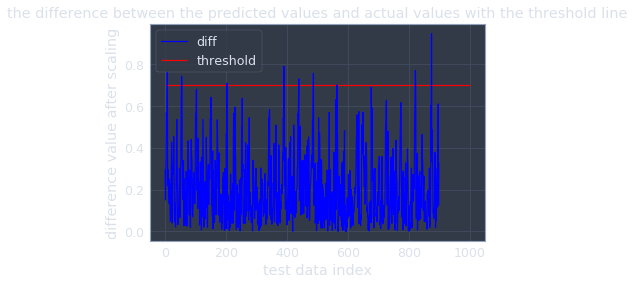

In [48]:
# plot the difference and the threshold (for the test data)
fig, axs = plt.subplots()

axs.plot(diff,color='blue', label='diff')
axs.set_title('the difference between the predicted values and actual values with the threshold line')

plt.hlines(threshold, 0, 1000, color='red', label='threshold')
plt.xlabel('test data index')
plt.ylabel('difference value after scaling')
plt.legend(loc='upper left')
plt.show()

In [49]:
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
last_train_data= (df['datetime'].tolist())[-testdatasize]
# add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')

* plot anomalies in the test data throughout time

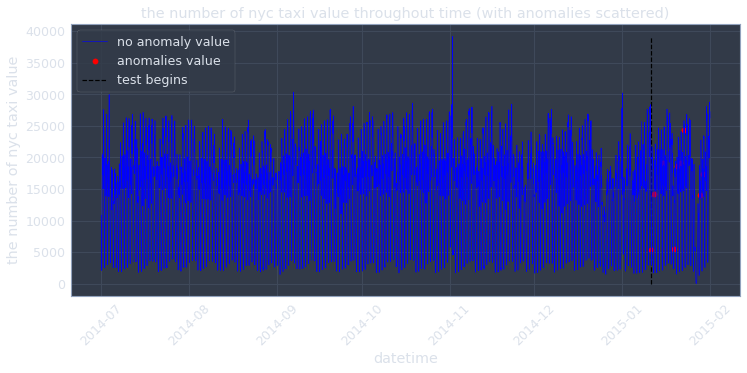

In [50]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(12, 5))

a = df.loc[df['anomaly27'] == 1, ['datetime', 'value']] #anomaly
ax.plot(df['datetime'], df['value'], color='blue', label='no anomaly value', linewidth=0.6)
ax.scatter(a['datetime'].tolist(),a['value'], color='red', label='anomalies value')
ax.set_title('the number of nyc taxi value throughout time (with anomalies scattered)')

max_value = df['value'].max()
min_value = df['value'].min()
plt.vlines(last_train_data, min_value, max_value, color='black', linestyles = "dashed", label='test begins')
plt.xlabel('datetime')
plt.xticks(rotation=45)
plt.ylabel('the number of nyc taxi value')
plt.legend(loc='upper left')
plt.show()